ML Olympiad - Quality Education

### Import das bibliotecas utilizadas

In [1]:
# matemática, estatística e etl
import pandas as pd
import numpy  as np
from tqdm        import tqdm
from math        import sqrt
from scipy       import stats
from scipy.stats import pearsonr

# visualização de dados
import seaborn           as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# outros
import gc
import warnings
from pylab                   import rcParams
from functools               import reduce
from IPython.display         import Image
from IPython.core.display    import HTML

# filtra warnings
warnings.filterwarnings("ignore")

# coordenadas geográficas
#!pip install geobr
import geobr
import geopandas as gpd


# parâmetros

def jupyter_settings():
    # plot de gráficos
    %matplotlib inline
    #%pylab inline
    #plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.rcParams['font.size'] = 30
    plt.style.use('ggplot')
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option("display.max_columns", 200)
    pd.set_option('display.max_rows', 200)
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    sns.set()
jupyter_settings()



### Auxiliar Functions

In [2]:
def reduce_mem_usage(df):
    """
    iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    fonte: https://www.kaggle.com/valleyzw/ubiquant-lgbm-baseline  
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm([x for x in df.columns if 'NU_NOTA_' not in x]):
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
 

def show_missings(df):
    '''
    mostra porcentagem de missings no dataframe
    '''
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})

    missing_value_df = missing_value_df.sort_values('percent_missing', ascending=False).round(2)
    return (missing_value_df)


def leitura_dados(path_train, path_test, sample_frac=-1):
    '''
    método para leitura dos datasets
    '''
    if sample_frac == -1:
        df_desenv = reduce_mem_usage(pd.read_csv(path_train))
    else:
        df_desenv = reduce_mem_usage(pd.read_csv(path_train).sample(frac=sample_frac, random_state=42))
    df_submit = reduce_mem_usage(pd.read_csv(path_test))
    return (df_desenv, df_submit)
        

def rmse_score(true, pred):
    '''
    rmse score
    '''
    return (sqrt(mean_squared_error(true, pred)))


def map_cor_raca(cor_raca):
    '''
    mapeia cor/raca de acordo com o metadados fornecido
    '''
    if cor_raca == 0:
        return 'Não informado'
    elif cor_raca == 1:
        return 'Branca'
    elif cor_raca == 2:
        return 'Preta'
    elif cor_raca == 3:
        return 'Parda'
    elif cor_raca == 4:
        return 'Amarela'
    elif cor_raca == 5:
        return 'Indígena'
    else:
        return ''


def map_estado_civil(estado_civil):
    '''
    mapeia estado civil de acordo com o metadados fornecido
    '''
    if estado_civil == 0:
        return 'Não informado'
    elif estado_civil == 1:
        return 'Solteiro(a)'
    elif estado_civil == 2:
        return 'Casado(a)/Mora com companheiro(a)'
    elif estado_civil == 3:
        return 'Divorciado(a)/Desquitado(a)/Separado(a)'
    elif estado_civil == 4:
        return 'Viúvo(a)'
    else:
        return ''


def gerar_painel_barra(data_frame,
                      var,
                      hue,
                      title = '',
                      title_subplot_1 = '',
                      title_subplot_2 = '',
                      legend_subplot_2 = '',
                      xlabel = 'Quantidade',
                      ylabel = '',
                      figsize = (12, 6)
                      ):
    '''
    gera gráfico de barras
    '''
    fig, ax = plt.subplots(1, 2, figsize = figsize)
    sns.countplot(data = data_frame,
                y = var,
                ax = ax[0])
    sns.countplot(data = data_frame,
                y = var,
                hue = hue,
                ax = ax[1])
    ax[0].set(ylabel = ylabel, xlabel = xlabel, title = title_subplot_1)
    ax[1].set(ylabel = ylabel, xlabel = xlabel, title = title_subplot_2)
    ax[1].legend(title = legend_subplot_2)
    fig.suptitle(title)
    fig.tight_layout(pad = 4)


def print_importancias_lasso(df, coef):
    '''
    importância das variáveis explicativas do modelo lasso
    '''
    for e in sorted (list(zip(list(df), coef)), key = lambda e: -abs(e[1])):
        if e[1] != 0:
            print('\t{}, {:.3f}'.format(e[0], e[1]))


def percentile(n):
    '''
    retorna percentil
    '''
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:2.0f}'.format(n*100)
    return percentile_


def estatistica_descritiva_por_estado(df, metrica):
    "Calcula alguma estatística descritiva para as notas do Enem por estado."
    # provas do dataset de base
    provas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
    # obtém os resultados por estado conforme medida estatística inserida
    df = df.groupby(by = 'SG_UF_RESIDENCIA', as_index = False)[provas].agg(metrica)
    # geolocalização
    df = gpd.GeoDataFrame(pd.merge(
    df,
    df_estados,
    left_on = 'SG_UF_RESIDENCIA',
    right_on = 'abbrev_state',
    how = 'inner'))

    return df


def plot_mapa_estado(df, estatistica_descritiva = np.mean, title = '', cmap = 'BuPu'):
    '''
    gera mapa heatmap para o Brasil populado com a estatística descritiva de interesse
    '''
    # cria o DataFrame conforme estatística descritiva definida
    df = estatistica_descritiva_por_estado(df=df, metrica = estatistica_descritiva)
    # labels para o pllot
    labels_provas = ['Ciências da Natureza', 'Ciências Humanas', 'Linguagens', 'Matemática', 'Redação']
    # colunas referentes a prova
    provas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
    # cria a figura
    fig, ax = plt.subplots(1, 5, figsize = (20, 20))
    # itera na lista de provas e cria o mapa
    for index, prova in enumerate(provas):
        df.plot(
            column = prova,
            cmap = cmap,
            edgecolor = 'lightgray',
            lw = 0.3,
            ax = ax[index],
            legend=True,
            legend_kwds = {'shrink': 0.08}
            )
        # remove marcações dos eixos
        ax[index].axis('off')
        # labels
        ax[index].set_title(labels_provas[index], fontsize  = 10)

        fig.suptitle(title, y = 0.6 , weight = 'bold')
        fig.tight_layout(pad = 2);


def Gerar_Grafico_Economico(Coluna):
    '''
    Função para gerar gráfico socio economico
    '''

    # Posicao
    Posicao_Index = 1

    # Ordenando os dados
    Filtro = Analise_Econominca.sort_values(by=str(Coluna))

    # Tamanho da Imagem
    fig, ax = plt.subplots(figsize=(18, 15))

    # Cor de fundo
    Cor_Fundo = "#F5F4EF"
    ax.set_facecolor(Cor_Fundo)
    fig.set_facecolor(Cor_Fundo)

    # Paleta de Cores
    Paleta_Cores = sns.color_palette('flare', 7)

    # Estilo do gráfico
    plt.style.use('seaborn-darkgrid')

    # Incluindo o Titulo na Figura
    plt.suptitle(f'Dados do Questionário Socieconômico | {Coluna}', 
             fontsize=22, color='#404040', fontfamily='KyivType Sans', fontweight=600 )

    # Loop plotar os gráficos
    for Grafico in Analise_Econominca[lista_targets]:

        # Retiando qlq valor zerado
        Filtro = Filtro.loc[ Filtro[Grafico] > 0 ]

        # Posição do Plot
        plt.subplot( 5, 1, Posicao_Index )

        # Plot
        sns.boxplot( data=Filtro, x=str(Coluna), y=Grafico, showmeans = True, linewidth=1, width=0.4, color=Paleta_Cores[Posicao_Index] )
        sns.stripplot( data=Filtro, x=str(Coluna), y=Grafico, size=0.3, color='0.1', linewidth=0 )

        # Titulo
        plt.title(f'Análise {Grafico}', loc='left', fontsize=14, fontweight=200)

        # Labels
        plt.ylabel('Nota de 0 - 1000')
        plt.xlabel('Resposta dos participantes')

        # Ajustando distancias dos gráficos no relatorio
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.94, wspace=0.2, hspace=0.25);

        # Troca index do Gráfico
        Posicao_Index += 1
        

def trata_predicoes(valor):
    '''
    garante que valores das notas estarão sempre entre 0 e 1000
    '''
    if valor < 0:
        return 0
    elif valor > 1000:
        return 1000
    else:
        return valor

### _Divide and conquer, to load data._

In [3]:
# Divisão das Variaveis
lista_targets = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
Variaveis_Socio_Economico = ['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025']
Variaveis_Atendimento_Especializado = ['IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF']
Variaveis_Cadastrais = ['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'CO_MUNICIPIO_NASCIMENTO', 'NO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'SG_UF_NASCIMENTO', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO']

# lista de variáveis explicativas para utilizar no modelo
lista_vars_explicativas = ['Q001','Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011','Q012', 'Q013',
                           'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021','Q022', 'Q023', 'Q024', 'Q025',
                           'IN_ACESSO', 'TP_ANO_CONCLUIU', 'TP_LINGUA', 'TP_SEXO', 'TP_DEPENDENCIA_ADM_ESC',
                           'NU_IDADE', 'TP_ESCOLA', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'IN_LIBRAS',
                           'CO_MUNICIPIO_RESIDENCIA', 'CO_ESCOLA', 'CO_MUNICIPIO_PROVA', 'CO_MUNICIPIO_PROVA',
                           'TP_ENSINO', 'SG_UF_PROVA', 'TP_ESTADO_CIVIL', 'TP_NACIONALIDADE',
                           'IN_SEM_RECURSO', 'IN_SALA_ESPECIAL', 'SG_UF_NASCIMENTO', 'SG_UF_ESC',
                           'IN_TREINEIRO', 'IN_DEFICIT_ATENCAO', 'TP_SIT_FUNC_ESC',
                           'CO_MUNICIPIO_ESC', 'IN_LEDOR', 'IN_TEMPO_ADICIONAL',
                           'IN_DEFICIENCIA_AUDITIVA', 'TP_LOCALIZACAO_ESC', 'IN_DEFICIENCIA_MENTAL',
                           'IN_SURDEZ', 'IN_AUTISMO', 'IN_DEFICIENCIA_FISICA', 'IN_TRANSCRICAO',
                           'CO_MUNICIPIO_NASCIMENTO', 'CO_MUNICIPIO_ESC', 'CO_UF_NASCIMENTO', 'CO_UF_PROVA',
                           'IN_MAQUINA_BRAILE', 'TP_PRESENCA_MT', 'TP_PRESENCA_LC',
                           'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_STATUS_REDACAO']
          

df_estados = geobr.read_state(year = 2019)

### Receive the Data

In [4]:
path_input_train= '../data/external/train.csv'
path_input_test= '../data/external/test.csv'
path_output_submission= '../data/external/sample_submission.csv'

In [5]:
# leitura dos dados (amostra de 5% para a base de treino)
df_desenv, df_submit = leitura_dados(path_input_train, path_input_test, sample_frac=0.05)
print (df_desenv.shape, df_submit.shape)

Memory usage of dataframe is 150.34 MB


100%|██████████| 113/113 [00:02<00:00, 48.63it/s]


Memory usage after optimization is: 36.03 MB
Decreased by 76.0%
Memory usage of dataframe is 1537.46 MB


100%|██████████| 113/113 [00:24<00:00,  4.65it/s]

Memory usage after optimization is: 321.90 MB
Decreased by 79.1%
(165596, 118) (1783345, 113)


# 1.0. Step 01 - Data Description

In [6]:
df1 = df_desenv.copy()

In [13]:
# dataframe de desenvolvimento
#df_desenv

# dataframe de submissão
#df_submit

## 1.1. Data Dimensions

In [7]:
# descritivo das variáveis do dataset
df1.describe()

,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,CO_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_TEMPO_ADICIONAL,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,CO_MUNICIPIO_PROVA,CO_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q005
count,165596.00,165596.00,165595.00,165596.00,165596.00,165596.00,160785.00,160785.00,165596.00,165596.00,165596.00,93440.00,165596.00,37464.00,37464.00,37464.00,37464.00,37464.00,37464.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,165596.00,120750.00,127625.00,127625.00,120750.00,165596.00,127625.00,127625.00,165596.00
mean,3085435.38,30.70,NaN,1.08,2.13,1.03,3057380.75,NaN,1.54,2.96,1.33,NaN,0.12,31232326.00,3125163.50,inf,inf,1.04,1.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3087178.04,30.72,0.73,0.77,0.77,0.73,477.85,507.15,520.49,523.23,0.53,NaN,570.76,3.87
std,996741.86,9.94,0.00,0.44,1.02,0.21,982356.62,0.00,0.72,4.11,0.55,0.00,0.33,9580825.00,961692.50,9.59,0.75,0.19,0.13,0.03,0.01,0.02,0.02,0.00,0.04,0.02,0.04,0.02,0.01,0.02,0.02,0.02,0.02,0.03,0.00,0.00,0.03,0.01,0.01,0.03,0.03,0.04,0.03,0.01,0.05,0.01,0.02,0.02,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.01,996964.41,9.94,0.44,0.42,0.42,0.44,76.10,82.55,64.39,108.92,0.50,0.00,189.20,1.48
min,1100015.00,11.00,12.00,0.00,0.00,0.00,1100015.00,11.00,1.00,0.00,1.00,1.00,0.00,11000058.00,1100015.00,11.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1100015.00,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
25%,2404606.00,24.00,18.00,1.00,1.00,1.00,2314102.00,23.00,1.00,0.00,1.00,1.00,0.00,23564318.00,2314102.00,23.00,2.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2407104.00,24.00,0.00,1.00,1.00,0.00,417.80,447.60,483.10,435.10,0.

In [8]:
# informações sobre o dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165596 entries, 3256928 to 2138594
Columns: 118 entries, NU_INSCRICAO to Q025
dtypes: category(34), float16(8), float32(3), float64(5), int32(2), int8(66)
memory usage: 36.0 MB


In [9]:
print(f'Total de linhas {df1.shape[0]} e Total de colunas {df1.shape[1]}.')

Total de linhas 165596 e Total de colunas 118.


## 1.2. Data Type

In [10]:
# tipo das variáveis do dataset
df1.dtypes

NU_INSCRICAO                   category
CO_MUNICIPIO_RESIDENCIA           int32
NO_MUNICIPIO_RESIDENCIA        category
CO_UF_RESIDENCIA                   int8
SG_UF_RESIDENCIA               category
NU_IDADE                        float16
TP_SEXO                        category
TP_ESTADO_CIVIL                    int8
TP_COR_RACA                        int8
TP_NACIONALIDADE                   int8
CO_MUNICIPIO_NASCIMENTO         float32
NO_MUNICIPIO_NASCIMENTO        category
CO_UF_NASCIMENTO                float16
SG_UF_NASCIMENTO               category
TP_ST_CONCLUSAO                    int8
TP_ANO_CONCLUIU                    int8
TP_ESCOLA                          int8
TP_ENSINO                       float16
IN_TREINEIRO                       int8
CO_ESCOLA                       float32
CO_MUNICIPIO_ESC                float32
NO_MUNICIPIO_ESC               category
CO_UF_ESC                       float16
SG_UF_ESC                      category
TP_DEPENDENCIA_ADM_ESC          float16


In [11]:
# lista de colunas do dataframe
df1.columns.tolist()

['NU_INSCRICAO',
 'CO_MUNICIPIO_RESIDENCIA',
 'NO_MUNICIPIO_RESIDENCIA',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_ESTADO_CIVIL',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'CO_MUNICIPIO_NASCIMENTO',
 'NO_MUNICIPIO_NASCIMENTO',
 'CO_UF_NASCIMENTO',
 'SG_UF_NASCIMENTO',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'IN_TREINEIRO',
 'CO_ESCOLA',
 'CO_MUNICIPIO_ESC',
 'NO_MUNICIPIO_ESC',
 'CO_UF_ESC',
 'SG_UF_ESC',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_LOCALIZACAO_ESC',
 'TP_SIT_FUNC_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DEFICIENCIA_AUDITIVA',
 'IN_SURDO_CEGUEIRA',
 'IN_DEFICIENCIA_FISICA',
 'IN_DEFICIENCIA_MENTAL',
 'IN_DEFICIT_ATENCAO',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_AUTISMO',
 'IN_VISAO_MONOCULAR',
 'IN_OUTRA_DEF',
 'IN_GESTANTE',
 'IN_LACTANTE',
 'IN_IDOSO',
 'IN_ESTUDA_CLASSE_HOSPITALAR',
 'IN_SEM_RECURSO',
 'IN_BRAILLE',
 'IN_AMPLIADA_24',
 'IN_AMPLIADA_18',
 'IN_LEDOR',
 'IN_ACESSO',
 'IN_TRANSCRICAO',
 'IN_LI

In [12]:
# colunas do target
df1[lista_targets].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
3256928,593.10,555.90,552.50,672.80,320.00
1884292,501.50,497.60,515.10,376.30,700.00
1237801,NaN,NaN,NaN,NaN,NaN
3060464,375.50,454.70,511.40,423.50,640.00
2945970,406.60,573.70,501.90,445.20,620.00


## 1.3. Check NA

In [13]:
# porcentagem de dados faltantes (missings) no dataset
show_missings(df1)

,column_name,percent_missing
CO_MUNICIPIO_ESC,CO_MUNICIPIO_ESC,77.38
TP_SIT_FUNC_ESC,TP_SIT_FUNC_ESC,77.38
TP_LOCALIZACAO_ESC,TP_LOCALIZACAO_ESC,77.38
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,77.38
SG_UF_ESC,SG_UF_ESC,77.38
CO_UF_ESC,CO_UF_ESC,77.38
NO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,77.38
CO_ESCOLA,CO_ESCOLA,77.38
TP_ENSINO,TP_ENSINO,43.57
NU_NOTA_MT,NU_NOTA_MT,27.08


In [14]:
# Total de NA's por coluna
df1.isna().sum()

NU_INSCRICAO                        0
CO_MUNICIPIO_RESIDENCIA             0
NO_MUNICIPIO_RESIDENCIA             0
CO_UF_RESIDENCIA                    0
SG_UF_RESIDENCIA                    0
NU_IDADE                            1
TP_SEXO                             0
TP_ESTADO_CIVIL                     0
TP_COR_RACA                         0
TP_NACIONALIDADE                    0
CO_MUNICIPIO_NASCIMENTO          4811
NO_MUNICIPIO_NASCIMENTO          4811
CO_UF_NASCIMENTO                 4811
SG_UF_NASCIMENTO                 4811
TP_ST_CONCLUSAO                     0
TP_ANO_CONCLUIU                     0
TP_ESCOLA                           0
TP_ENSINO                       72156
IN_TREINEIRO                        0
CO_ESCOLA                      128132
CO_MUNICIPIO_ESC               128132
NO_MUNICIPIO_ESC               128132
CO_UF_ESC                      128132
SG_UF_ESC                      128132
TP_DEPENDENCIA_ADM_ESC         128132
TP_LOCALIZACAO_ESC             128132
TP_SIT_FUNC_

# 2.0 EDA

In [15]:
df2 = df1.copy()

In [16]:
# quantidade de valores únicos em cada coluna
df2.nunique()

NU_INSCRICAO                   165596
CO_MUNICIPIO_RESIDENCIA          5276
NO_MUNICIPIO_RESIDENCIA          5022
CO_UF_RESIDENCIA                   27
SG_UF_RESIDENCIA                   27
NU_IDADE                           65
TP_SEXO                             2
TP_ESTADO_CIVIL                     5
TP_COR_RACA                         6
TP_NACIONALIDADE                    5
CO_MUNICIPIO_NASCIMENTO          4953
NO_MUNICIPIO_NASCIMENTO          4720
CO_UF_NASCIMENTO                   27
SG_UF_NASCIMENTO                   27
TP_ST_CONCLUSAO                     4
TP_ANO_CONCLUIU                    14
TP_ESCOLA                           3
TP_ENSINO                           2
IN_TREINEIRO                        2
CO_ESCOLA                       15250
CO_MUNICIPIO_ESC                 4080
NO_MUNICIPIO_ESC                 3917
CO_UF_ESC                          27
SG_UF_ESC                          27
TP_DEPENDENCIA_ADM_ESC              4
TP_LOCALIZACAO_ESC                  2
TP_SIT_FUNC_

In [17]:
# Analysis of metrics
num_attributes = df2.select_dtypes( include=['int8', 'int32', 'float32', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int8', 'int32', 'float32', 'float64'] )

In [18]:
# Central tendency - mean and median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

# Rename columns
m.columns = ( ['attributes', 'min', 'max', 'mean', 'median', 'range', 'std', 'skew', 'kurtosis',] )
m 

,attributes,min,max,mean,median,range,std,skew,kurtosis
0,CO_MUNICIPIO_RESIDENCIA,1100015.00,5300108.00,4200093.00,3085435.38,3124252.50,996738.85,0.27,-0.15
1,CO_UF_RESIDENCIA,11.00,53.00,42.00,30.70,31.00,9.94,0.30,-0.12
2,TP_ESTADO_CIVIL,0.00,4.00,4.00,1.08,1.00,0.44,1.94,8.76
3,TP_COR_RACA,0.00,5.00,5.00,2.13,2.00,1.02,-0.10,-1.16
4,TP_NACIONALIDADE,0.00,4.00,4.00,1.03,1.00,0.21,7.61,79.94
5,CO_MUNICIPIO_NASCIMENTO,1100015.00,5300108.00,4200093.00,3057380.75,NaN,982353.56,0.29,-0.09
6,TP_ST_CONCLUSAO,1.00,4.00,3.00,1.54,1.00,0.72,1.00,-0.15
7,TP_ANO_CONCLUIU,0.00,13.00,13.00,2.96,1.00,4.11,1.40,0.69
8,TP_ESCOLA,1.00,3.00,2.00,1.33,1.00,0.55,1.45,1.13
9,IN_TREINEIRO,0.00,1.00,1.00,0.12,0.00,0.33,2.32,3.37


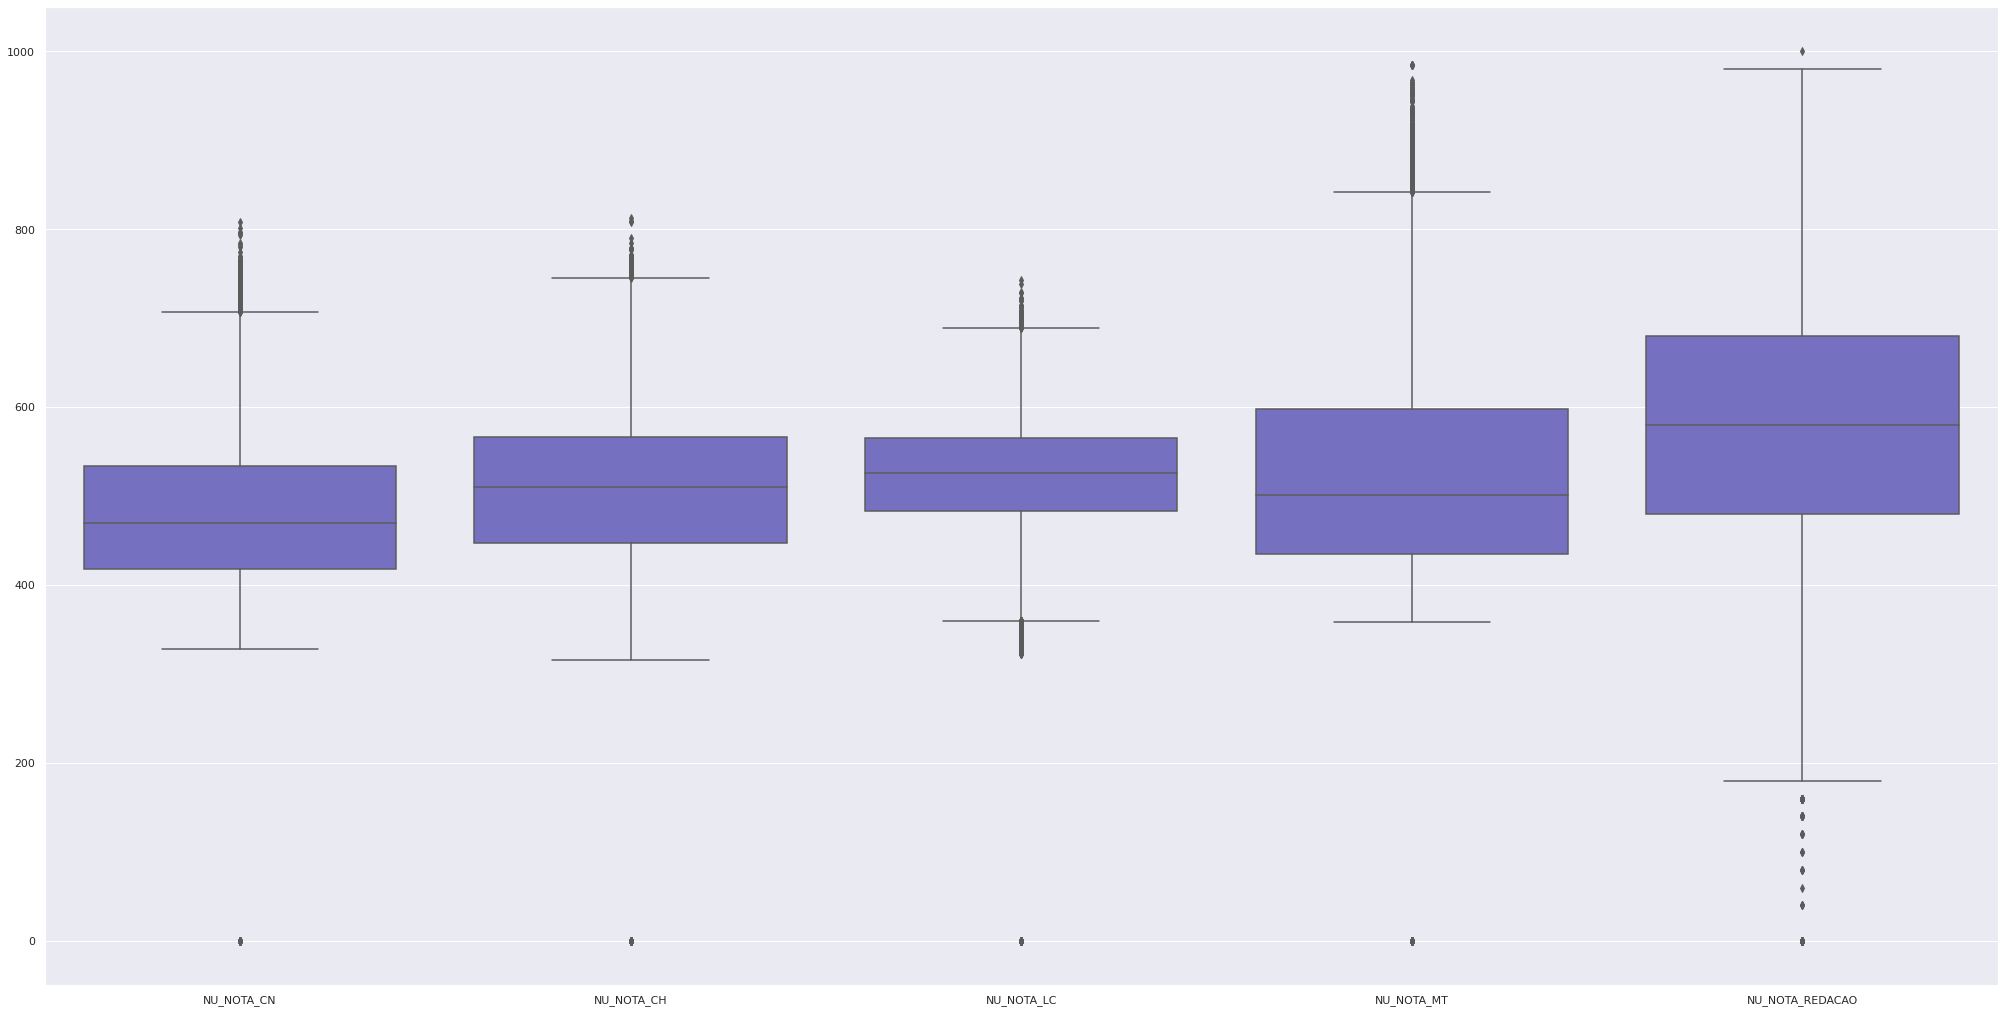

In [ ]:
# Analise de outliers entre as notas do Enem
fig, ax = plt.subplots(figsize = (35, 18))
sns.boxplot(data = df2[lista_targets], color='#6B62CE', ax = ax);

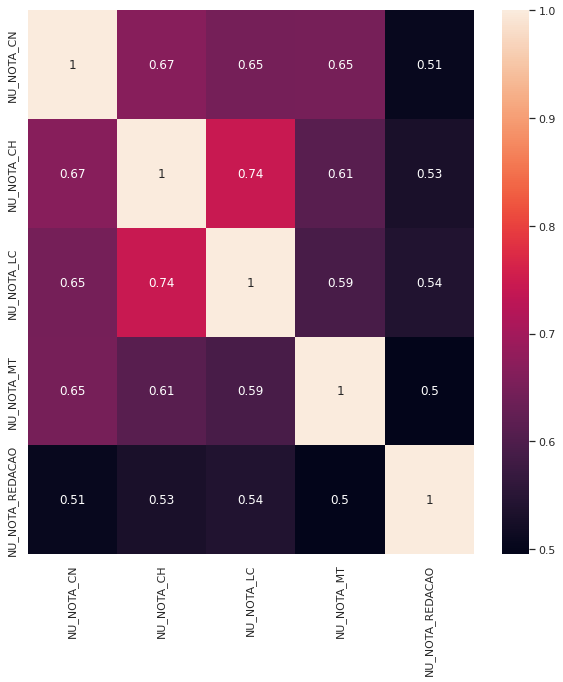

In [26]:
# Correlação entre as notas das provas do Enem
fig, ax = plt.subplots()
corr_provas = df2[lista_targets].corr()
sns.heatmap(corr_provas, annot=True, ax = ax);

In [27]:
# frequência dos inscritos no Enem por UF
df2['SG_UF_RESIDENCIA'].value_counts(dropna=False, ascending=False, normalize=True)

SP   0.16
MG   0.11
BA   0.08
RJ   0.07
CE   0.06
PA   0.06
PE   0.05
MA   0.04
RS   0.04
PR   0.04
GO   0.03
PB   0.03
PI   0.02
AM   0.02
RN   0.02
SC   0.02
ES   0.02
DF   0.02
AL   0.02
MT   0.02
SE   0.02
MS   0.01
RO   0.01
TO   0.01
AC   0.01
AP   0.01
RR   0.00
Name: SG_UF_RESIDENCIA, dtype: float64

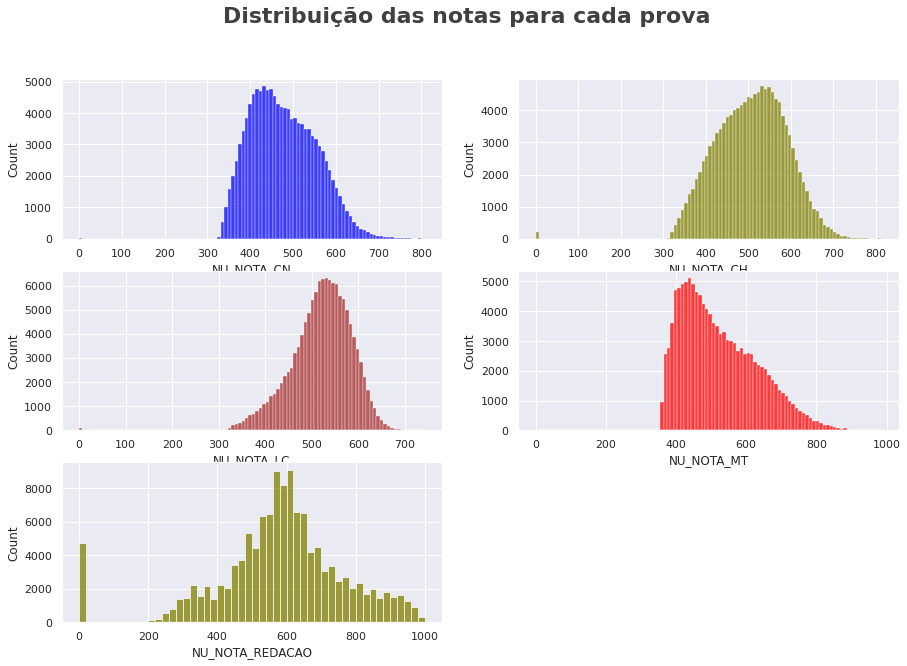

In [28]:
# Analisando Notas por Estado (UF)
Analise_Target = df2[['SG_UF_RESIDENCIA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']]

# Criando o relátorio
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Plotando as notas em histogramas
sns.histplot(data=Analise_Target, x='NU_NOTA_CN', color='blue', bins=100, ax=axs[0, 0])
sns.histplot(data=Analise_Target, x='NU_NOTA_CH', color='olive', bins=100, ax=axs[0, 1])
sns.histplot(data=Analise_Target, x='NU_NOTA_LC', color='brown', bins=100, ax=axs[1, 0])
sns.histplot(data=Analise_Target, x='NU_NOTA_MT', color='red', bins=100, ax=axs[1, 1])
sns.histplot(data=Analise_Target, x='NU_NOTA_REDACAO', color='olive', bins=50, ax=axs[2, 0])
axs[2, 1].set_axis_off()

# Incluindo o Titulo na Figura
plt.suptitle('Distribuição das notas para cada prova', fontsize=22, color='#404040', fontweight=600);

Idade média: nan
Idade mediana: 19.0
Idade mais frequente (moda): 18.0


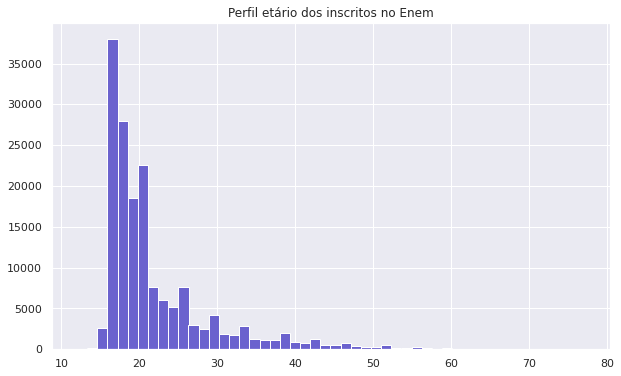

In [39]:
# Idade
print ('Idade média:', round(df2.query("NU_IDADE == NU_IDADE")['NU_IDADE'].mean(), 2))
print ('Idade mediana:', round(df2.query("NU_IDADE == NU_IDADE")['NU_IDADE'].median(), 2))
print ('Idade mais frequente (moda):', round(df2.query("NU_IDADE == NU_IDADE")['NU_IDADE'].mode()[0], 2))
plt.subplots(figsize=(10, 6))
plt.hist(df2['NU_IDADE'], color='#6B62CE', bins=50);
plt.title('Perfil etário dos inscritos no Enem');

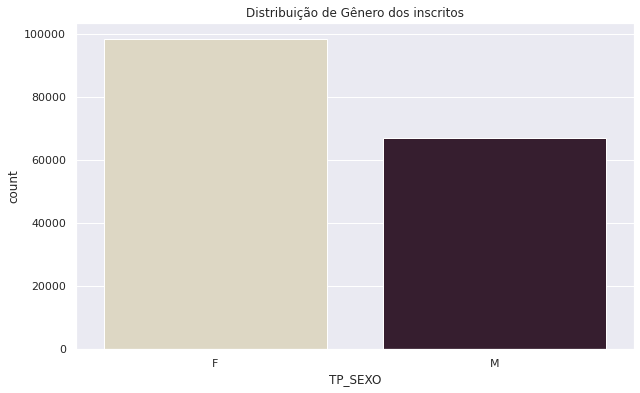

In [40]:
# Gênero
plt.subplots(figsize=(10, 6))
sns.countplot(x='TP_SEXO', data=df2, palette="ch:.36")
plt.title('Distribuição de Gênero dos inscritos');

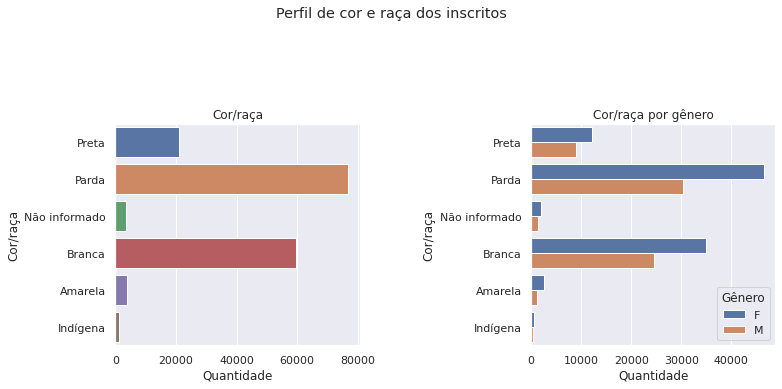

In [38]:
# Cor da pele
df2['MAP_TP_COR_RACA'] = df2['TP_COR_RACA'].apply(map_cor_raca)
gerar_painel_barra(df2, 'MAP_TP_COR_RACA', 'TP_SEXO', 
                   title = 'Perfil de cor e raça dos inscritos',
                   title_subplot_1 = 'Cor/raça',
                   title_subplot_2 = 'Cor/raça por gênero',
                   legend_subplot_2 = 'Gênero',
                   ylabel = 'Cor/raça');

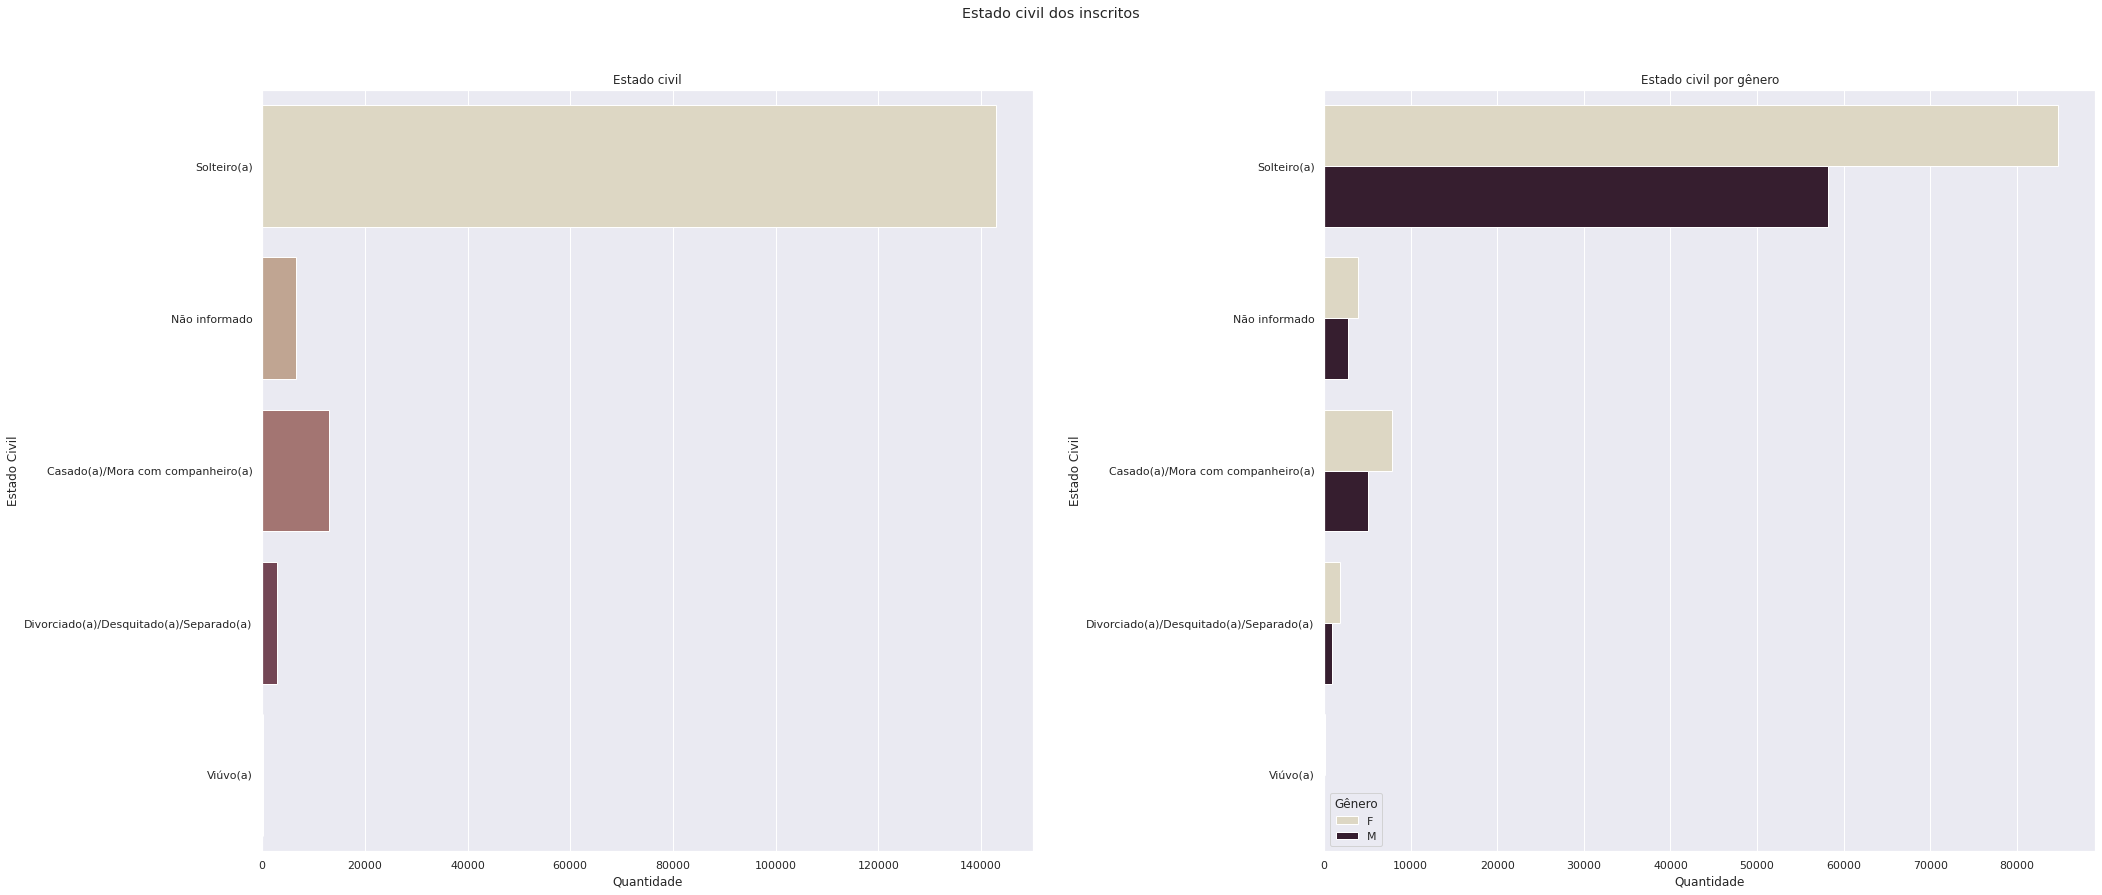

In [49]:
# Estado civil
df2['MAP_TP_ESTADO_CIVIL'] = df2['TP_ESTADO_CIVIL'].apply(map_estado_civil)
        
fig, ax = plt.subplots(1,2, figsize = (30, 13))
sns.countplot(data = df2, y = 'MAP_TP_ESTADO_CIVIL',palette="ch:.36", ax = ax[0])
sns.countplot(data = df2, y = 'MAP_TP_ESTADO_CIVIL',palette="ch:.36", hue = 'TP_SEXO', ax = ax[1])
ax[0].set(ylabel = 'Estado Civil', xlabel = 'Quantidade',title = 'Estado civil')
ax[1].set(ylabel = 'Estado Civil', xlabel = 'Quantidade',title = 'Estado civil por gênero')
ax[1].legend(title = 'Gênero')
fig.suptitle('Estado civil dos inscritos')
fig.tight_layout(pad = 3);

# 3.0. Feature Engineering

In [51]:
df3 = df2.copy()

In [52]:
# Calcula a quantidade de inscritos em cada estado (amostra)
df_inscritos_por_estado = df3.groupby(by = 'SG_UF_RESIDENCIA')[['SG_UF_RESIDENCIA']].count()\
.rename(columns = {'SG_UF_RESIDENCIA': 'quantidade_inscritos'})\
.reset_index()\
.sort_values(by = 'quantidade_inscritos', ascending = False)

In [53]:
df_inscritos_por_estado.head(27)

,SG_UF_RESIDENCIA,quantidade_inscritos
25,SP,26454
10,MG,17641
4,BA,12740
18,RJ,11027
5,CE,9546
13,PA,9294
15,PE,8736
9,MA,7254
22,RS,7003
17,PR,6824
